---
### select and show anchors
- how many anchor will selected as positives, like this anchor ...
- In this threshold ...

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

with open("./stat_csv/statics_anchors1234_thresh0.5.csv", "r") as f:
    out = pd.read_csv(f)
    
def overlap_per_range(data, points=6, max_res=300):
    data = data.copy()
    criterion = (np.sqrt(data[["gt_size"]])*max_res).values
    data["criterion"] = criterion
    x = np.linspace(0, max_res, points+1)
    bins = list()
    for i in range(len(x)-1):
        mask_data = data.values[np.where((criterion>=x[i]) & (criterion<x[i+1]))[0]]
        mask_data = pd.DataFrame(mask_data, columns=data.columns)
        bins.append(overlap_all(mask_data))
    return x, bins

def overlap_all(data):
    num_objects = len(data)
    all_num_anchors = int(data[["num_anchors"]].sum())
    try:
        out = all_num_anchors / num_objects
    except ZeroDivisionError:
        out = 0
    return out

def show_bar(X,Y,save=False):
    plt.rcParams["font.size"]=16
    plt.figure(figsize=(10,6))
    plt.rcParams['legend.fontsize'] = 13
    plt.rcParams['legend.handlelength'] = 2
    
    for key in X.keys():
        x = X[key]
        y = Y[key]        
        plt.bar(x[:-1], height=y, width=x[1], align="edge", label=key)
        plt.grid()
        plt.ylabel("mean positive anchors")
        plt.xlabel("ground truth box scale")
        plt.title("pos anchors per range")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.subplots_adjust(left=0.1, right=0.8)
    plt.show()

In [53]:
X, Y = dict(), dict()
for thresh in [0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    with open(f"./stat_csv/statics_anchors1234_thresh{thresh}.csv", "r") as f:
        out = pd.read_csv(f)
    x, y = overlap_per_range(out, points=100)
    X[thresh] = x
    Y[thresh] = y

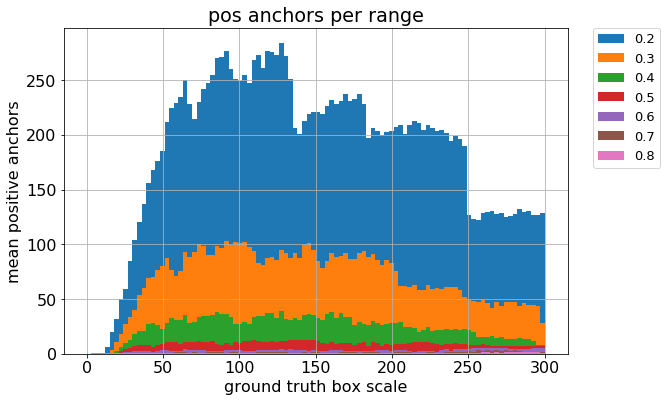

In [67]:
show_bar(X, Y)

---
### number of matching anchors

In [4]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from vision.ssd.ssd import MatchPrior
from vision.utils import box_utils
from vision.utils.box_utils import (assign_priors, center_form_to_corner_form, 
                                    corner_form_to_center_form, iou_of, for_statics_anchors)
from vision.ssd.config import vgg_ssd_config

config = vgg_ssd_config
img_size = 300

match_prioir = MatchPrior(config.priors, config.center_variance, config.size_variance, iou_threshold=0.5)
corner_priors = center_form_to_corner_form(config.priors.clone())
center_priors = config.priors.clone()

%load_ext autoreload
%autoreload 2

from vision.datasets.voc_dataset import VOCDataset
from vision.ssd.ssd import MatchPrior
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform
from torch.utils.data import DataLoader, Dataset, ConcatDataset

matching_iou = 0.5

train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance, config.size_variance, iou_threshold=matching_iou, stat=True)

def bbox(img, bb):
    h, w = img.shape[:2]
    bb[:, [0,2]] *= int(w)
    bb[:, [1,3]] *= int(h)
    for i in range(len(bb)):
        img = cv2.rectangle(img, (bb[i,0],bb[i,1]), (bb[i,2],bb[i,3]), (255,0,0), 2)
    return img


In [5]:
# train_dataset = VOCDataset(dataset_path, transform=train_transform, target_transform=target_transform)
train_dataset07 = VOCDataset("/mnt/hdd01/img_data/VOCdevkit/VOC2007", transform=train_transform, target_transform=target_transform)
train_dataset12 = VOCDataset("/mnt/hdd01/img_data/VOCdevkit/VOC2012", transform=train_transform, target_transform=target_transform)
train_dataset = ConcatDataset([train_dataset07, train_dataset12])

# img, bb, cl = train_dataset[2]

In [6]:
# --- w/o stat
print(bb)
priors = corner_priors[cl == 15].clone()
plt.imshow(bbox(img.permute(1,2,0).numpy(), priors)/50)
wo_stat = cl.clone()

NameError: name 'bb' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.5140, 0.5253, 0.5920, 0.8747],
        [0.5140, 0.5253, 0.5920, 0.8747],
        [0.5140, 0.5253, 0.5920, 0.8747],
        ...,
        [0.1360, 0.4560, 0.5380, 0.8773],
        [0.1360, 0.4560, 0.5380, 0.8773],
        [0.1360, 0.4560, 0.5380, 0.8773]])


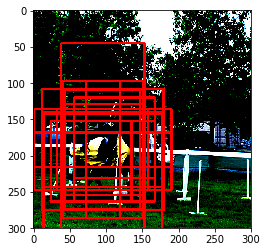

In [74]:
# --- w/ stat
print(bb)
priors = corner_priors[cl == 13].clone()
plt.imshow(bbox(img.permute(1,2,0).numpy(), priors)/50)
w_stat = cl.clone()

---
### anchor overlaps
---

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

with open("./visualize_anchors_overlap_shapes/statics_anchors.csv", "r") as f:
    data = pd.read_csv(f)

In [2]:
def overlap_all(data):
    num_objects = len(data)
    all_num_anchors = int(data[["num_anchors"]].sum())
    try:
        out = all_num_anchors / num_objects
    except ZeroDivisionError:
        out = 0
    return out
    
def overlap_per_area(data, points=10, max_res=300):
    criterion = (np.sqrt(data[["gt_size"]])*300).values
    x = np.linspace(0, 300, points+1)
    result = list()
    for thresh in x:
        mask_data = data[criterion<=thresh]
        result.append(overlap_all(mask_data))
    return x, result

def overlap_per_range(data, points=5):
    data = data.copy()
    criterion = (np.sqrt(data[["gt_size"]])*300).values
    data["criterion"] = criterion
    x = np.linspace(0, 300, points+1)
    bins = list()
    for i in range(len(x)-1):
        mask_data = data.values[np.where((criterion>=x[i]) & (criterion<x[i+1]))[0]]
        mask_data = pd.DataFrame(mask_data, columns=data.columns)
        bins.append(overlap_all(mask_data))
    return x, bins

In [3]:
x, y = overlap_per_area(data, points=100)

FigureCanvasNbAgg()

Text(0.5, 0, 'ground truth box scale')

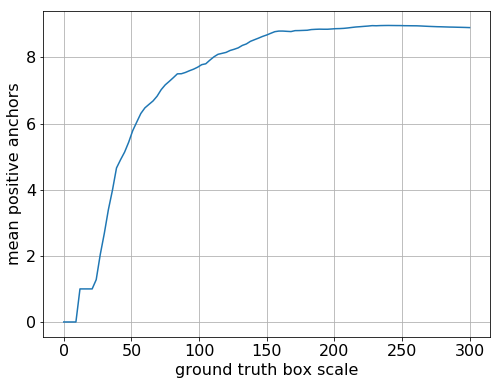

In [23]:

plt.rcParams["font.size"]=16
plt.figure(figsize=(8,6))
plt.plot(x,y)
plt.grid(True)
plt.ylabel("mean positive anchors")
plt.xlabel("ground truth box scale")
